In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score


df = pd.read_csv("SeoulBikeDataClean.csv")

# Time-based train/val/test split
train_df = df[df['datetime'] < '2018-10-01']
val_df   = df[(df['datetime'] >= '2018-10-01') & (df['datetime'] < '2018-11-01')]
test_df  = df[df['datetime'] >= '2018-11-01']

print("Train:", train_df.shape)
print("Val:  ", val_df.shape)
print("Test: ", test_df.shape)


Train: (6984, 40)
Val:   (665, 40)
Test:  (648, 40)


In [2]:
# Feature selection and data preparation
import lightgbm as lgb

full_features = ['temperaturec', 'humiditypct',
       'wind_speed_m_s', 'visibility_10m', 'dew_point_temperaturec',
       'solar_radiation_mj_m2', 'Autumn',
       'Spring', 'Summer', 'Winter', 'phase0to6', 'phase7to9', 'phase10to17', 'phase18to19', 'phase20to24', 'is_raining',
       'is_snowing', 'temperaturec_squared', 'is_weekend', 'is_holiday',
       'is_working_day', 'temp_rain', 'temp_snow', 'humid_rain', 'lag_1',
       'lag_24', 'rolling_24_mean', 'rolling_168_mean']

X_train = train_df[full_features]
y_train = train_df['rented_bike_count']

X_val = val_df[full_features]
y_val = val_df['rented_bike_count']

X_test = test_df[full_features]
y_test = test_df['rented_bike_count']

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val   = lgb.Dataset(X_val, y_val, reference=lgb_train)


In [3]:
# Train LightGBM model (compatible version)

from lightgbm import early_stopping, log_evaluation

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'val'],
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=20)
    ]
)

Training until validation scores don't improve for 10 rounds
[20]	train's rmse: 290.824	val's rmse: 330.625
[40]	train's rmse: 173.089	val's rmse: 239.002
[60]	train's rmse: 138.257	val's rmse: 219.894
[80]	train's rmse: 125.708	val's rmse: 214.22
[100]	train's rmse: 118.136	val's rmse: 212.26
Early stopping, best iteration is:
[99]	train's rmse: 118.426	val's rmse: 211.765


 Test RMSE: 179.12
 Test R²:   0.8454


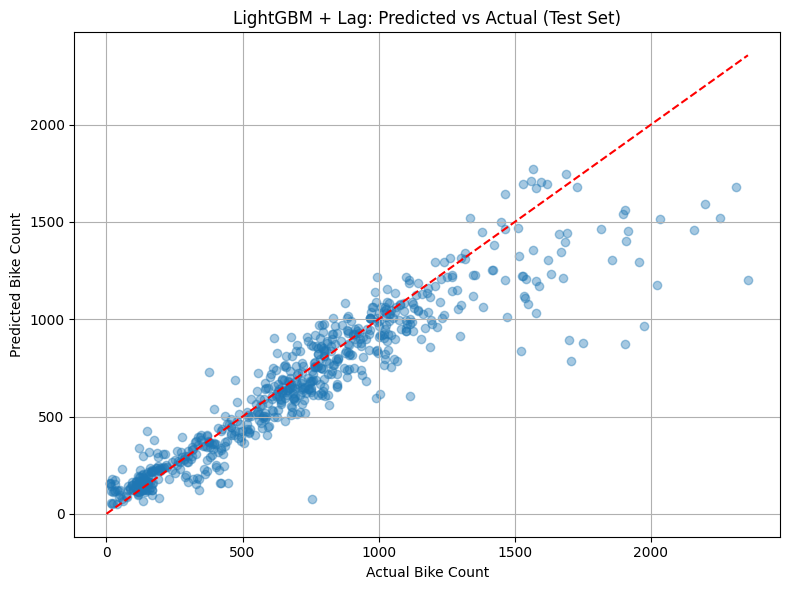

In [4]:
# Predict on test set and evaluate

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f" Test RMSE: {rmse:.2f}")
print(f" Test R²:   {r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("LightGBM + Lag: Predicted vs Actual (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()
